#Data 

In [49]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

## 사진 400장 train/test set 나누기


In [50]:
def train_test(test_a,test_b):
  subject_train=[]
  for i in range(1,test_a):
    path = '/content/drive/MyDrive/att_faces/s'+str(i)
    file_list = os.listdir(path)
    for j in range(10):
      with Image.open(path+"/"+file_list[j]) as im:
        a= np.asarray(im)
        new_a=a.reshape(112*92,)
        subject_train.append(new_a)
  
  for i in range(test_b,41):
    path = '/content/drive/MyDrive/att_faces/s'+str(i)
    file_list = os.listdir(path)
    for j in range(10):
      with Image.open(path+"/"+file_list[j]) as im:
        a= np.asarray(im)
        new_a=a.reshape(112*92,)
        subject_train.append(new_a)
  subject_train=np.asarray(subject_train)

  subject_test=[]
  for i in range(test_a,test_b):
    path = '/content/drive/MyDrive/att_faces/s'+str(i)
    file_list = os.listdir(path)
    for j in range(10):
      with Image.open(path+"/"+file_list[j]) as im:
        a= np.asarray(im)
        new_a=a.reshape(112*92,)
        subject_test.append(new_a)
  subject_test=np.asarray(subject_test)
  
  return subject_train,subject_test

In [51]:
def plot_faces(pixels):
    fig, axes = plt.subplots(5, 20, figsize=(20, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.array(pixels)[i].reshape(112, 92), cmap='gray')
    plt.show()

#plot_faces(subject_train)

#PCA

##pca 함수

In [52]:
class my_PCA():

    def __init__(self, N):
        #N(축소시킬 차원)
        self.N = N
        self.eigen_matrics = None
        self.eigen_value = None
        
    def get_eigen(self, data):
        n, d = data.shape # 400,10304
        
        # np.linalg.eigh 이용해서
        #eigen value, eigen vector 계산하기
        eigvalues, eigvectors = np.linalg.eigh(np.matmul(data.T, data)/n) 
        
        # eigen value와 vectors 짝지어서 저장.
        eigen_values_vectors = [(eigvalues[a], eigvectors[:, a]) for a in range(d)]
        
        # eigen value 값에 따라 내림차순 정렬 
        eigen_sorting = sorted(eigen_values_vectors, key=lambda tup: tup[0], reverse=True)
        
        # eigen vector 쌓아서 행렬 만들기. 
        self.eigen_matrics = np.stack(list(map(lambda tup: tup[1], eigen_sorting)), axis=1)
        
        # eigen value 모아서 벡터 만들기. 
        self.eigen_values = np.array(list(map(lambda tup: tup[0], eigen_sorting)))
        
        #sorting 안하고 순서대로 eigen matrics 뽑은거
        self.eigen_not_sorting_matrics = np.stack(list(map(lambda tup: tup[1], eigen_values_vectors)), axis=1)

    def dimension_reduction(self, data):
        
        # N개의 eigen vector로 행렬만들기.
        N_eigen_matrics = self.eigen_matrics[:, :self.N]
        
        # 차원 축소해서 정사영시킨 결과값들.
        final_y = np.matmul(data, N_eigen_matrics)

        return final_y,N_eigen_matrics, self.eigen_matrics, self.eigen_not_sorting_matrics

##차원축소시키기

In [53]:
def result(test_a,test_b):
  subject_train=train_test(test_a,test_b)[0]
  subject_test=train_test(test_a,test_b)[1]
  # 평균 빼서 데이터 원점으로 옮기기.
  subject_to_origin = subject_train - np.mean(subject_train, axis=0, keepdims=True)
  #3차원으로 차원축소
  pca = my_PCA(N=3)
  #eigen vector 구하기
  pca.get_eigen(subject_to_origin)

  #주성분 축 행렬로 만들기 and 확인
  N_eigen_matrics = pca.dimension_reduction(subject_to_origin)[1]
  #N_eigen_matrics.shape

  #차원축소 잘되었는지 확인
  final_y=pca.dimension_reduction(subject_to_origin)[0]
  #print(final_y.shape)
  eigen_matrics=pca.dimension_reduction(subject_to_origin)[2]

  #eigenface_vectors=N_eigen_matrics.T[0].reshape(112,92)
  #plt.imshow(eigenface_vectors)
  return N_eigen_matrics,final_y,eigen_matrics

In [38]:
results=result(37,41)
N_eigen_matrics,final_y,eigen_matrics=results[0],results[1],results[2]


##Eigen face 그리기 

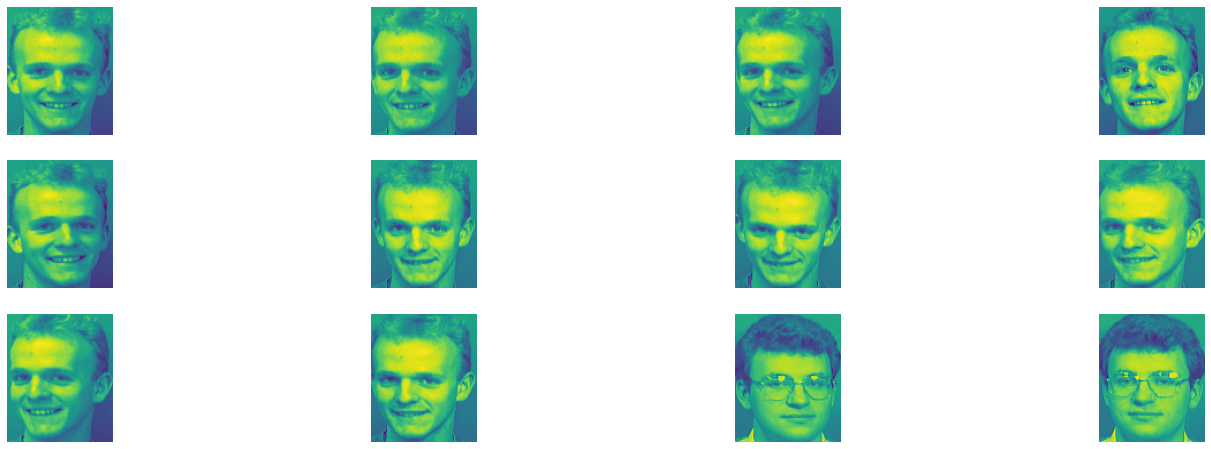

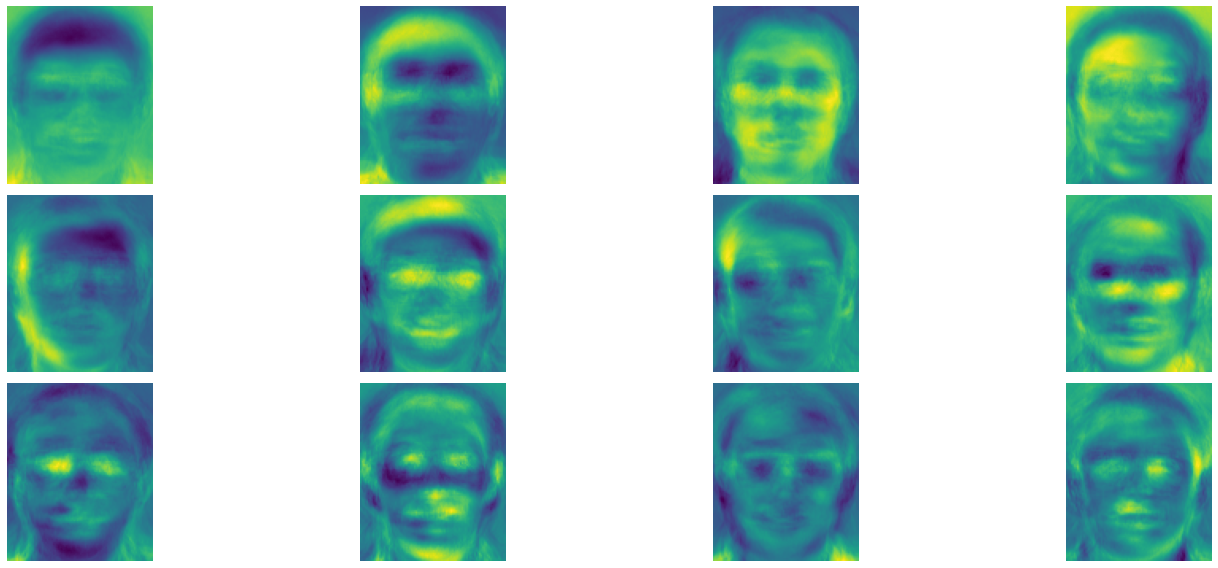

In [40]:
test_a=1
test_b=5
subject_train=train_test(test_a,test_b)[0]
subject_train=subject_train.reshape(360,10304)
#사진그리기
def draw_origin(rows,cols,pixel):

    axes=[]
    fig=plt.figure(figsize=(25, 8))

    for a in range(rows*cols):
        b =pixel[a].reshape(112,92)
        axes.append( fig.add_subplot(rows, cols, a+1) )
        plt.axis('off')
        plt.imshow(b)
    plt.show()
def draw_projection(rows,cols,pixel):      
    axes=[]
    fig=plt.figure(figsize=(22, 8))
    for a in range(rows*cols):
        b =eigen_matrics.T[a].reshape(112,92)
        axes.append( fig.add_subplot(rows, cols, a+1) )
        plt.axis('off')
        plt.imshow(b)
    fig.tight_layout()    
    plt.show()

draw_origin(3,4,subject_train)
draw_projection(3,4,eigen_matrics)

##Test set으로 reconstructed  image 보기.

In [54]:
def Final_y_test(test_a,test_b,N_d):
  subject_test=train_test(test_a,test_b)[1]
  # 평균 빼서 데이터 원점으로 옮기기.
  subject_test_mean = np.mean(subject_test, axis=0, keepdims=True)
  subject_test_origin = subject_test - subject_test_mean

  #3차원으로 차원축소
  pca = my_PCA(N=N_d)
  pca.get_eigen(subject_test_origin)
  final_y_test=pca.dimension_reduction(subject_test_origin)[0]
  return final_y_test
def reconstruction(test_a,test_b):  
  subject_test=train_test(test_a,test_b)[1]
  N_eigen_matrics=result(test_a,test_b)[0]
  subject_test_mean = np.mean(subject_test, axis=0, keepdims=True)
  reconstructed_data = np.matmul(final_y_test,N_eigen_matrics.T)+subject_test_mean
  return reconstructed_data

In [43]:
final_y_test=Final_y_test(37,41,3)
#reconstructed_data=reconstruction(37,41)

In [44]:
reconstructed_data=reconstruction(37,41)

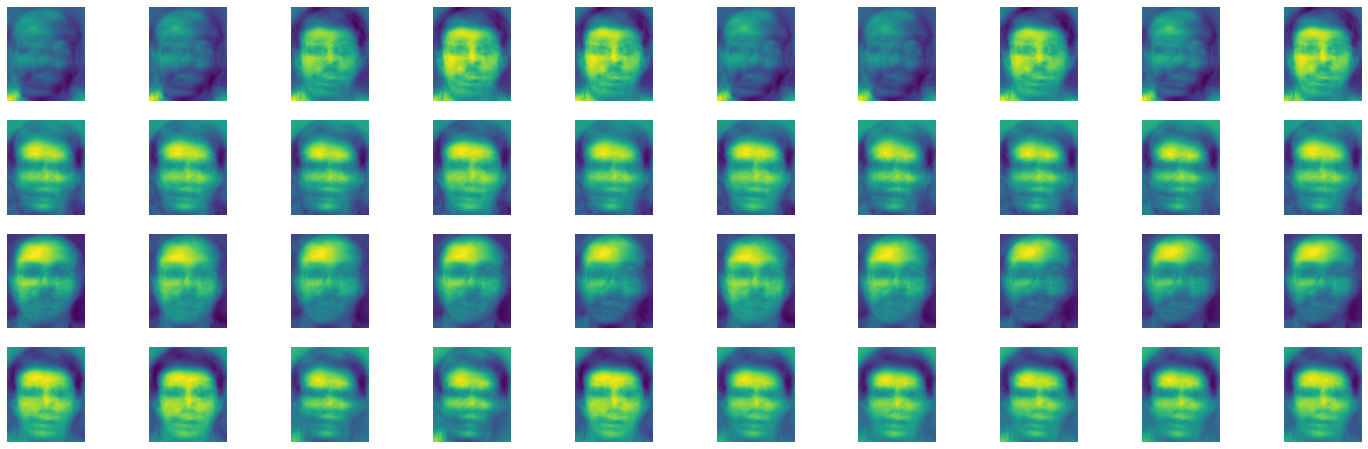

In [45]:
draw_origin(4,10,reconstructed_data)

##3D PCA space scatter

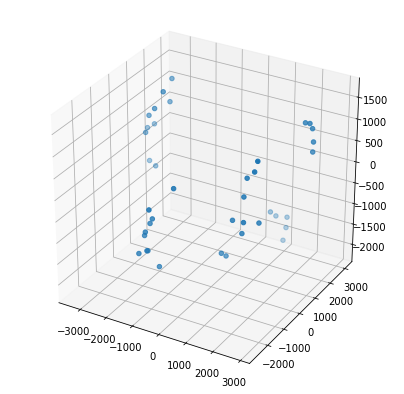

In [55]:
def draw_scatter(data):
    x = data[:,0]
    y = data[:,1]
    z = data[:,2]

    fig = plt.figure(figsize=(7, 7))
    ax = fig.gca(projection='3d')

    ax.scatter(data[:,0], data[:,1], data[:,2])

    plt.show()

draw_scatter(final_y_test)   

##gallery and query

In [56]:
def pointDist(x,y):
  sum=0
  for i in range(len(x)):
    sum+=(x[i]-y[i])**2
  dist=sum**(1/2)
  return dist


In [57]:
def Confusion_matrix(final_y_test,N_d):
    subject1=final_y_test[:10,:]
    subject2=final_y_test[10:20,:]
    subject3=final_y_test[20:30,:]
    subject4=final_y_test[30:41,:]

    subject_gallery=[]
    subject_gallery.append(subject1[3:11,:])
    subject_gallery.append(subject2[3:11,:])
    subject_gallery.append(subject3[3:11,:])
    subject_gallery.append(subject4[3:11,:])
    subject_gallery=np.asarray(subject_gallery).reshape(28,N_d)

    subject_query=[]
    subject_query.append(subject1[:3,:])
    subject_query.append(subject2[:3,:])
    subject_query.append(subject3[:3,:])
    subject_query.append(subject4[:3,:])
    subject_query=np.asarray(subject_query).reshape(12,N_d)

    dist=[]
    for abc in range(len(subject_query)):
          for gq in range(len(subject_gallery)):
                  dist.append(pointDist(subject_query[abc],subject_gallery[gq]))
    dist=np.asarray(dist)
    dist=dist.reshape(12,28)
    knn=np.argsort(dist, axis=1)[:, :7] 
    labeledKNN = knn//7

    c = []
    for row in labeledKNN:
      temp = [0 for i in range(4)]
      for i in range(7):
        temp[row[i]]+=1
      c.append(temp)
      
    splitedC = np.split(np.array(c), 4, axis=0)
    pred = []
    for row in splitedC:
      pred.append(np.sum(row, axis=0))
    pred=np.array(pred)/21.*100
    return pred

In [58]:
def ten_fold_N_dimension(N_d):
  ten_fold=[]
  for n in range(1,38,4):
    final_y_test=Final_y_test(n,n+4,N_d)
    ten_fold.append(Confusion_matrix(final_y_test,N_d))

  ten_fold=np.array(ten_fold)
  FINAL_CONFUSION_MATRICS=np.sum(ten_fold, axis=0)/10
  print("FINAL_CONFUSION_MATRICS",FINAL_CONFUSION_MATRICS)
  
  accuracy=0
  for i in range(4):
    accuracy+=FINAL_CONFUSION_MATRICS[i][i]
  accuracy=accuracy/4 
  print("accuracy",accuracy)
  return FINAL_CONFUSION_MATRICS,accuracy

## ten fold validation 결과

###D=1000일때 CONFUSION MATRIX

In [27]:
###D=1000일때 
x=[1000]
D_accuracy=[]
for x in x:
  D_accuracy.append(ten_fold_N_dimension(x)[1])
print(D_accuracy)
'''
FINAL_CONFUSION_MATRICS 
[[90.          6.66666667  1.9047619   1.42857143]
 [ 2.38095238 95.71428571  0.95238095  0.95238095]
 [ 6.19047619  3.80952381 86.19047619  3.80952381]
 [ 2.85714286  9.52380952  5.23809524 82.38095238]]
accuracy 88.57142857142856
'''

FINAL_CONFUSION_MATRICS [[90.          6.66666667  1.9047619   1.42857143]
 [ 2.38095238 95.71428571  0.95238095  0.95238095]
 [ 6.19047619  3.80952381 86.19047619  3.80952381]
 [ 2.85714286  9.52380952  5.23809524 82.38095238]]
accuracy 88.57142857142856
[88.57142857142856]


'\nFINAL_CONFUSION_MATRICS [[66.33333333 19.          6.          8.66666667]\n [20.         69.          7.33333333  3.66666667]\n [16.         12.33333333 63.66666667  8.        ]\n [15.66666667  9.66666667 11.66666667 63.        ]]\naccuracy 65.5\nFINAL_CONFUSION_MATRICS [[66.33333333 19.          6.          8.66666667]\n [20.         69.          7.33333333  3.66666667]\n [16.         12.33333333 63.66666667  8.        ]\n [15.66666667  9.66666667 11.66666667 63.        ]]\naccuracy 65.5\n[65.5, 65.5]\n'

###D=50일때, 100일때 CONFUSION MATRIX

In [28]:
x=[50,100]
D_accuracy=[]
for x in x:
  D_accuracy.append(ten_fold_N_dimension(x)[1])
print(D_accuracy)
'''
FINAL_CONFUSION_MATRICS [[90.          6.66666667  1.9047619   1.42857143]
 [ 2.38095238 95.71428571  0.95238095  0.95238095]
 [ 6.19047619  3.80952381 86.19047619  3.80952381]
 [ 2.85714286  9.52380952  5.23809524 82.38095238]]
accuracy 88.57142857142856
FINAL_CONFUSION_MATRICS [[90.          6.66666667  1.9047619   1.42857143]
 [ 2.38095238 95.71428571  0.95238095  0.95238095]
 [ 6.19047619  3.80952381 86.19047619  3.80952381]
 [ 2.85714286  9.52380952  5.23809524 82.38095238]]
accuracy 88.57142857142856
[88.57142857142856, 88.57142857142856]
'''

FINAL_CONFUSION_MATRICS [[90.          6.66666667  1.9047619   1.42857143]
 [ 2.38095238 95.71428571  0.95238095  0.95238095]
 [ 6.19047619  3.80952381 86.19047619  3.80952381]
 [ 2.85714286  9.52380952  5.23809524 82.38095238]]
accuracy 88.57142857142856
FINAL_CONFUSION_MATRICS [[90.          6.66666667  1.9047619   1.42857143]
 [ 2.38095238 95.71428571  0.95238095  0.95238095]
 [ 6.19047619  3.80952381 86.19047619  3.80952381]
 [ 2.85714286  9.52380952  5.23809524 82.38095238]]
accuracy 88.57142857142856
[88.57142857142856, 88.57142857142856]


'\nINAL_CONFUSION_MATRICS [[66.33333333 19.          6.          8.66666667]\n [20.         69.          7.33333333  3.66666667]\n [16.         12.33333333 63.66666667  8.        ]\n [15.66666667  9.66666667 11.66666667 63.        ]]\naccuracy 65.5\nFINAL_CONFUSION_MATRICS [[66.33333333 19.          6.          8.66666667]\n [20.         69.          7.33333333  3.66666667]\n [16.         12.33333333 63.66666667  8.        ]\n [15.66666667  9.66666667 11.66666667 63.        ]]\naccuracy 65.5\n[65.5, 65.5]\n'

###D=3일때, 10일때 CONFUSION MATRIX

In [29]:
x=[3,10]
D_accuracy=[]
for x in x:
  D_accuracy.append(ten_fold_N_dimension(x)[1])
print(D_accuracy)


'''
FINAL_CONFUSION_MATRICS [[92.85714286  3.33333333  1.42857143  2.38095238]
 [ 0.         96.19047619  2.38095238  1.42857143]
 [ 0.          3.33333333 90.          6.66666667]
 [ 1.9047619   5.23809524  7.61904762 85.23809524]]
accuracy 91.07142857142857
FINAL_CONFUSION_MATRICS [[87.61904762  7.61904762  1.42857143  3.33333333]
 [ 1.42857143 95.71428571  1.9047619   0.95238095]
 [ 6.66666667  3.80952381 84.76190476  4.76190476]
 [ 3.33333333  9.52380952  5.23809524 81.9047619 ]]
accuracy 87.5
[91.07142857142857, 87.5]
'''

FINAL_CONFUSION_MATRICS [[92.85714286  3.33333333  1.42857143  2.38095238]
 [ 0.         96.19047619  2.38095238  1.42857143]
 [ 0.          3.33333333 90.          6.66666667]
 [ 1.9047619   5.23809524  7.61904762 85.23809524]]
accuracy 91.07142857142857
FINAL_CONFUSION_MATRICS [[87.61904762  7.61904762  1.42857143  3.33333333]
 [ 1.42857143 95.71428571  1.9047619   0.95238095]
 [ 6.66666667  3.80952381 84.76190476  4.76190476]
 [ 3.33333333  9.52380952  5.23809524 81.9047619 ]]
accuracy 87.5
[91.07142857142857, 87.5]


'\nFINAL_CONFUSION_MATRICS [[67.66666667 16.66666667  6.66666667  9.        ]\n [17.         69.          8.66666667  5.33333333]\n [12.66666667 10.         66.         11.33333333]\n [13.66666667  8.66666667 13.33333333 64.33333333]]\naccuracy 66.75\nFINAL_CONFUSION_MATRICS [[65.33333333 20.33333333  5.33333333  9.        ]\n [20.         69.          6.66666667  4.33333333]\n [15.66666667 12.33333333 62.66666667  9.33333333]\n [15.         11.         12.         62.        ]]\naccuracy 64.75\n'

###D=4일때 CONFUSION MATRIX

In [30]:
x=[4]
D_accuracy=[]
for x in x:
  D_accuracy.append(ten_fold_N_dimension(x)[1])
print(D_accuracy)
'''
FINAL_CONFUSION_MATRICS [[90.95238095  3.80952381  1.42857143  3.80952381]
 [ 0.47619048 98.0952381   0.          1.42857143]
 [ 4.28571429  2.85714286 87.14285714  5.71428571]
 [ 3.33333333  4.28571429  3.33333333 89.04761905]]
accuracy 91.3095238095238
[91.3095238095238]
'''

FINAL_CONFUSION_MATRICS [[90.95238095  3.80952381  1.42857143  3.80952381]
 [ 0.47619048 98.0952381   0.          1.42857143]
 [ 4.28571429  2.85714286 87.14285714  5.71428571]
 [ 3.33333333  4.28571429  3.33333333 89.04761905]]
accuracy 91.3095238095238
[91.3095238095238]


##축소한 차원에 따른 성능 비교 결과 

"PCA를 n차원으로 축소했을 때 정확도 표"

In [68]:
import pandas as pd
accuracy=[91.07,91.31,87.5,88.57,88.57,88.57]
raw_data = {'Dimension':accuracy}
df = pd.DataFrame(accuracy, columns = ['PCA_Accuracy'],
                  index=['d=3', 'd=4', 'd=10', 'd=50','d=100','d=1000'])
print(df)
print("")



        PCA_Accuracy
d=3            91.07
d=4            91.31
d=10           87.50
d=50           88.57
d=100          88.57
d=1000         88.57

